In [1]:
import os
import configparser

import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import mapping
from rasterio import mask as msk
import earthpy.spatial as es

from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
# played around with quite a few colour palettes before settling on one
from palettable.cartocolors.sequential import Magenta_7, PurpOr_5, Sunset_5, Teal_7, agGrnYl_5_r
from palettable.cmocean.sequential import Deep_14, Matter_20, Dense_20
from palettable.matplotlib import Magma_20_r

In [3]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

# Shaded Relief map

Followed [this great tutorial](https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3) by Adam Symington.

Elevation data is GMTED2010 and downloaded [here](https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm). Used [Natural Earth](https://www.naturalearthdata.com/) data to clip the raster data to the country shape. Hillshades are accessed via the [earthpy](https://earthpy.readthedocs.io/en/latest/index.html) library.

Finally, colours come from [palettable](https://jiffyclub.github.io/palettable/).

In [4]:
# import terrain elevation data
file = rasterio.open('30N120E_20101117_gmted_mea075.tif')
dataset = file.read()
print(dataset.shape)

# load countries shapefile
ne = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(ne, ne)))
japan = countries.loc[countries['ADMIN'] == 'Japan']

(1, 9600, 14400)


In [5]:
# function to clip elevation file to country outline
def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)],
                                                           crop=True, nodata=(np.amax(clipped_array[0]) + 1))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

japan_topography, value_range = clip_raster(japan, file)

In [6]:
# get hillshades
hillshade = es.hillshade(japan_topography[0], azimuth=90, altitude=30)
hillshade[hillshade == 191.25] = 35

In [7]:
# amend colour palette so that the highest value = given background colour
def get_colormap(hex_colors, bg_color):
    listed_colormap = colors.LinearSegmentedColormap.from_list('colorpalette', hex_colors, N=value_range) 
    bg_color = np.array(colors.to_rgba(bg_color))
    newcolors = listed_colormap(np.linspace(0, 1, value_range))
    cmap_new = colors.ListedColormap(np.vstack((newcolors, bg_color)))
    return cmap_new

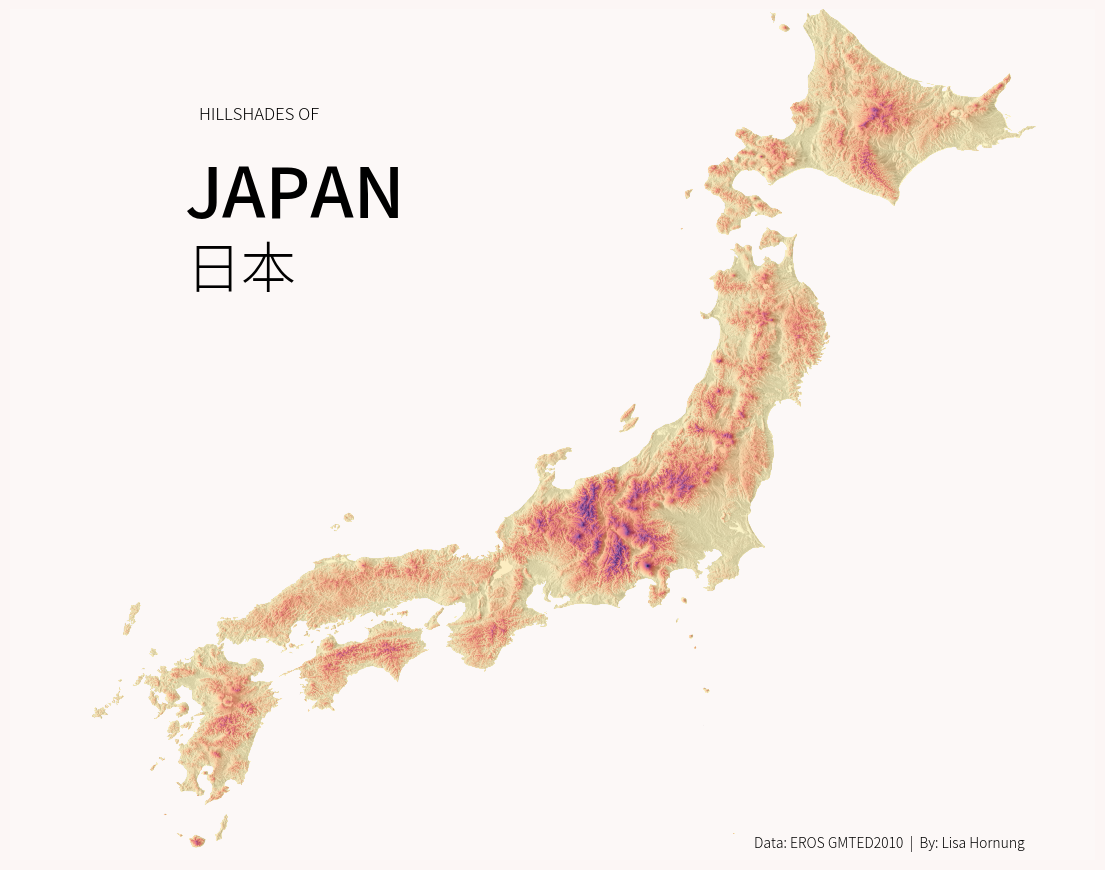

In [8]:
# map

#set colours and font
bg_color = '#fcf6f5'
hex_colors = Magma_20_r.hex_colors
cmap_new = get_colormap(hex_colors, bg_color)
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')

# plot
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(bg_color)

plt.imshow(japan_topography[0], cmap=cmap_new, interpolation='nearest')
ax.imshow(hillshade, cmap="Greys", alpha=0.3, vmin=50)

# style
ax.set_xlim(xmin=2000, xmax=11500)
ax.axis('off')

#title
plt.figtext(0.26, 0.77 -0.05, "Hillshades of".upper(), fontproperties=subtitle_font, fontsize=12,  ha="left")
plt.figtext(0.25, 0.7-0.05, "Japan".upper(), fontproperties=title_font, fontsize=50,  ha="left")
plt.figtext(0.25, 0.65-0.05, "日本", fontproperties=subtitle_font, fontsize=40, ha="left")

plt.figtext(0.85, 0.2, "Data: EROS GMTED2010  |  By: Lisa Hornung", fontproperties=subtitle_font, fontsize=10, ha="right")

plt.savefig("shaded-relief-japan.png", bbox_inches='tight', pad_inches=0.45, facecolor=bg_color)

plt.show()

# Playground

In [285]:
from shapely.geometry import Point

#dictionary of places to map
places = {"Tokyo | 東京都": [35.68177934327633, 139.77231855645576], 
          "Kyoto": [34.99873865808107, 135.77330077649881]
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])

geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places

,lat,lon,geometry
Tokyo | 東京都,35.681779,139.772319,POINT (139.77232 35.68178)
Kyoto,34.998739,135.773301,POINT (135.77330 34.99874)


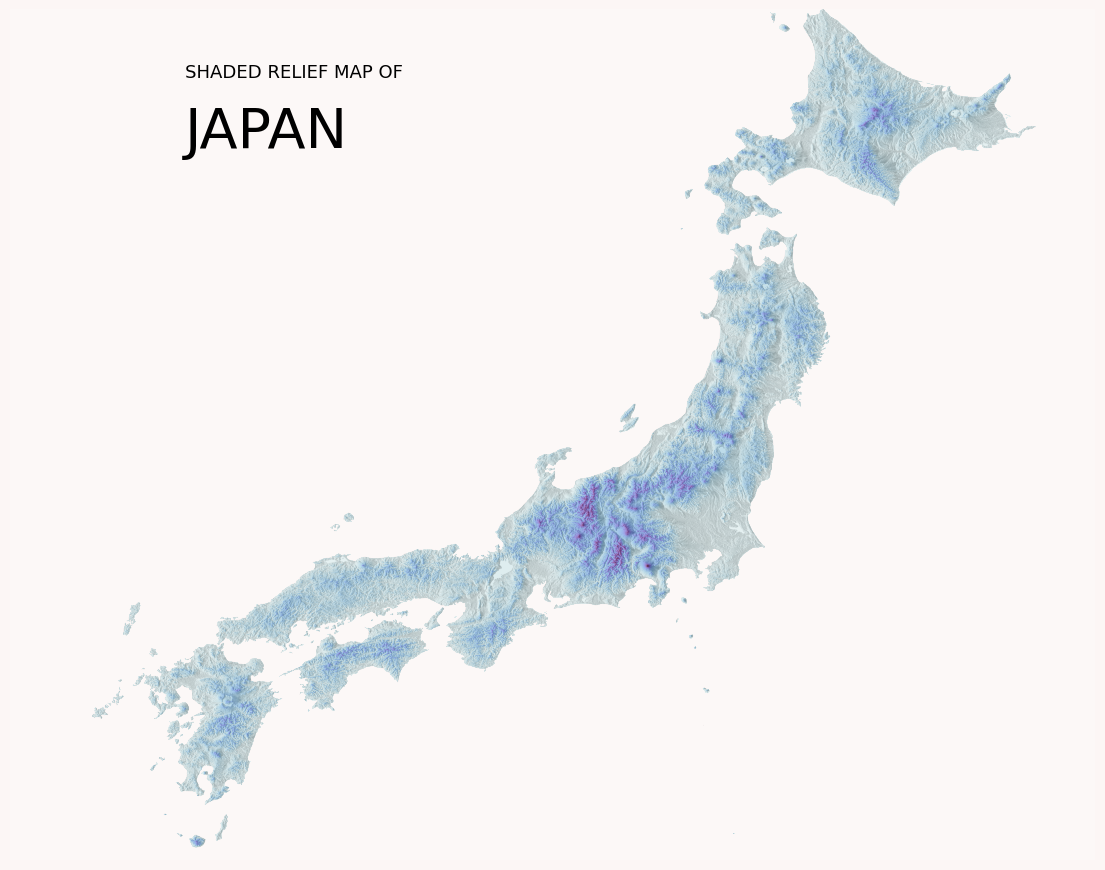

In [265]:
bg_color = '#fcf6f5'
hex_colors = Dense_20.hex_colors
cmap_new = get_colormap(hex_colors, bg_color)

fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(bg_color)

plt.imshow(japan_topography[0], cmap=cmap_new, interpolation='nearest')
ax.imshow(hillshade, cmap="Greys", alpha=0.3, vmin=50)

ax.set_xlim(xmin=2000, xmax=11500)
ax.axis('off')

#title
plt.figtext(0.25, 0.75, "Shaded relief map of".upper(), fontsize=13,  ha="left")
plt.figtext(0.25, 0.7, "Japan".upper(), fontsize=40,  ha="left")

#plt.savefig("shaded-relief-japan.png", bbox_inches='tight', pad_inches=0.15, facecolor=bg_color)

plt.show()

In [11]:
# import terrain elevation data
file = rasterio.open('30N120E_20101117_gmted_mea075.tif')
dataset = file.read()
print(dataset.shape)

(1, 9600, 14400)


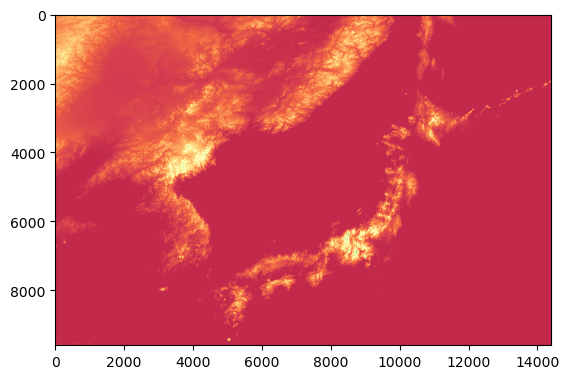

In [2]:
plt.imshow(dataset[0], cmap='Spectral')
plt.show()

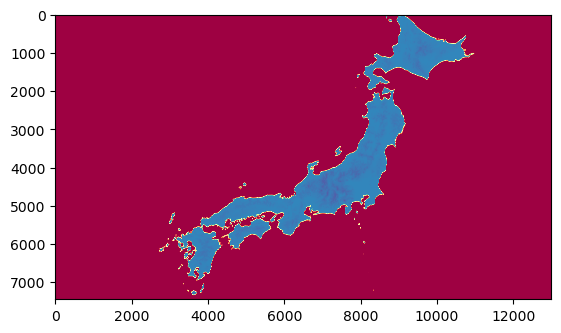

In [15]:
# load countries shapefile
ne = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(ne, ne)))
japan = countries.loc[countries['ADMIN'] == 'Japan']

clipped_array, clipped_transform = msk.mask(file, [mapping(japan.iloc[0].geometry)], crop=True)

plt.imshow(clipped_array[0], cmap='Spectral')
plt.show()